# RPGF3 Projects on Open Source Observer

###  RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "OSS Projects on Open Source Observer"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-07_RPGF3xOSO.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list awards one OP token to any RPGF3 project that is represented on",
                "https://opensource.observer. Only projects with unique, public GitHub repos",
                "included in their application have been indexed by OSO. Two tokens are awarded",
                "to projects that were in a prior RPGF and/or included either a contract address",
                "or NPM package url in their application."
                ]) 

DISCLAIMER = " ".join([
                "Note: lists generated by the OSO team do not include OSO in them in order to comply",
                "with voting rules, so please consider adding our project to your ballot separately."
                ])
            
LIST_CATS = [
            'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

JSON_PATH = DATA_DIR + "lists/RPGF3xOSO.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()

slugs = slugs[slugs!='opensource-observer']
del slugs_to_ids['opensource-observer']

#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
    WITH Rpgf AS (
        SELECT DISTINCT p.slug
        FROM collection c
        JOIN collection_projects_project cpp ON c."id" = cpp."collectionId"
        JOIN project p on cpp."projectId" = p."id"
        WHERE c.slug IN ('op-rpgf1', 'op-rpgf2')
    )
    , Counter AS (
        SELECT p.slug, COUNT(DISTINCT a.id) AS artifact_count
        FROM project p
        JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
        JOIN artifact a ON paa."artifactId" = a."id"
        WHERE 
            p.slug IN ('{slugs_list}') 
            AND a.namespace <> 'ETHEREUM' 
            AND a.type IN ('CONTRACT_ADDRESS', 'FACTORY_ADDRESS', 'NPM_PACKAGE')
        GROUP BY p.slug
    )
    SELECT 
        p.slug,
        CASE WHEN p.slug IN (SELECT slug FROM Rpgf) THEN 1 ELSE 0 END AS past_rpgf,
        CASE WHEN (SELECT artifact_count FROM Counter WHERE Counter.slug = p.slug) > 0 THEN 1 ELSE 0 END AS has_artifact_count
    FROM project p
    WHERE p.slug IN ('{slugs_list}')    
    ORDER BY p.slug;     
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

rpgf_oso = {p: 1*(r|a)+1 for (p,r,a) in results}
rpgf_oso

{'0x-splits': 2,
 '1w3': 2,
 'abi-to-sol-gnidan': 1,
 'across': 2,
 'acrypto-s': 2,
 'aerodrome-finance': 1,
 'aestus-relay': 1,
 'agoraxyz': 2,
 'alchemyplatform': 2,
 'alembic-tech': 1,
 'alloy-rs': 1,
 'alphadayhq': 1,
 'another-world': 2,
 'anotherblock': 2,
 'ape-framework': 2,
 'arbiter-primitivefinance': 1,
 'arpa-network': 1,
 'attestation-station-interface-sbvegan': 2,
 'attestation-visualizer-xvoorvaa': 1,
 'aw-labs': 2,
 'awesome-optimism-lucas-op': 1,
 'aya-labs': 1,
 'bankless-academy': 2,
 'bankless-card': 1,
 'banklessdao': 2,
 'basepunkorg': 1,
 'beacon-chain': 2,
 'blobscan': 2,
 'blockhead-darryl-yeo': 1,
 'blocknative': 1,
 'blockscout': 2,
 'blst-supranational': 2,
 'boardroom-inc': 2,
 'bonding-curves': 1,
 'bootnodedev': 1,
 'brightid': 2,
 'buidlguidl': 2,
 'bunnyai-justindomingue': 1,
 'bwarelabs': 2,
 'candide-labs': 2,
 'cannon-rs-badboilabs': 2,
 'chainlist-defillama': 2,
 'chainpatrol': 1,
 'charmverse': 1,
 'chronicleprotocol': 2,
 'cliqueofficial': 2,
 'co

# Generate the list

In [6]:
award_amt = sum(rpgf_oso.values())
award_amt

485

In [7]:
named_list = listify(rpgf_oso, award_amt)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

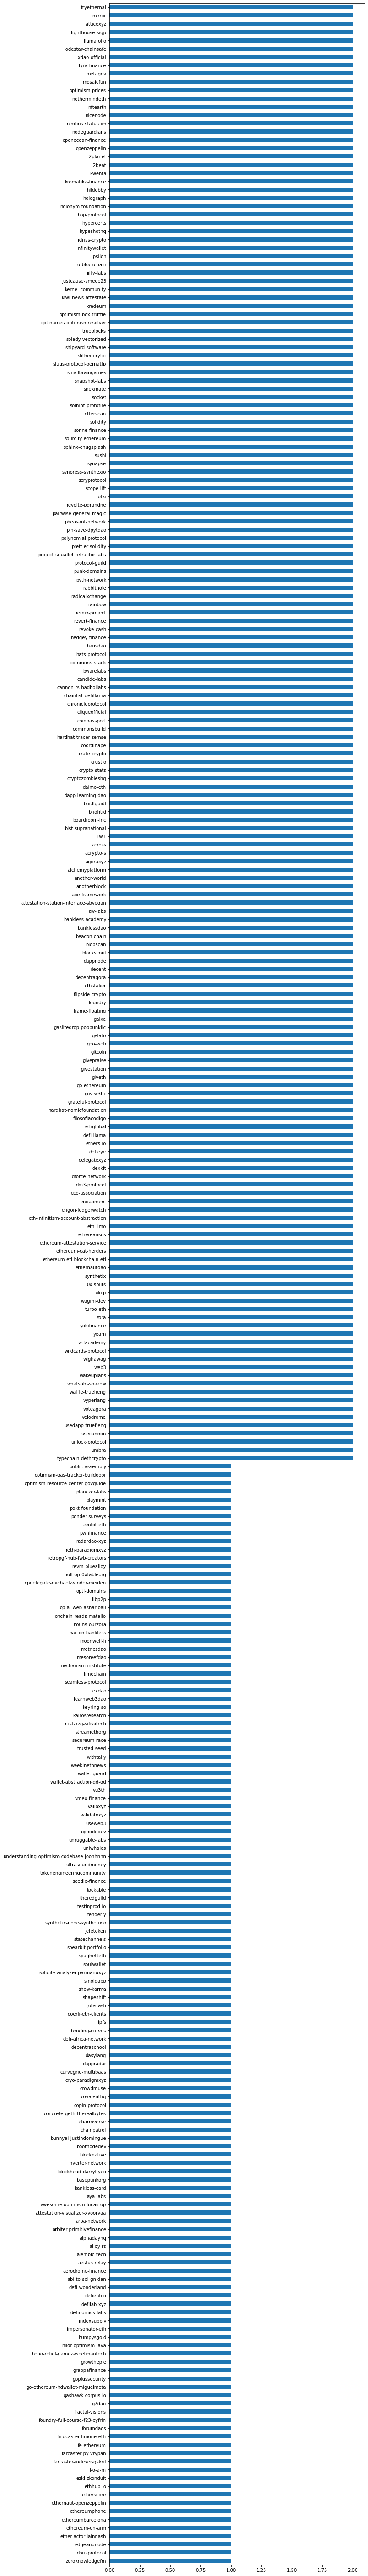

In [8]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [9]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [10]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)